# R4 on Plant Phenotyping Dataset

In [11]:
%load_ext autoreload
%autoreload 2
import torch
import tqdm
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.abspath('..'))
from models.R4_models import PlantNet
from models.robust_regularizer import input_gradient_interval_regularizer
from models.pipeline import (train_model_with_pgd_robust_input_grad, train_model_with_certified_input_grad,
                             test_model_accuracy, test_delta_input_robustness, write_results_to_file,
                             load_params_or_results_from_file, uniformize_magnitudes_schedule)
from datasets import plant

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Get the dataloaders 

In [12]:
CUDA_LAUNCH_BLOCKING=1
SEED = 0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
torch.manual_seed(SEED)
batch_size = 50
test_batch_size = 25

cuda:0


In [13]:
SPLIT_ROOT = "/vol/bitbucket/mg2720/plant/rgb_dataset_splits"
DATA_ROOT = "/vol/bitbucket/mg2720/plant/rgb_data"
MASKS_FILE = "/vol/bitbucket/mg2720/plant/mask/preprocessed_masks.pyu"

plant_train_2 = plant.PlantDataset(SPLIT_ROOT, DATA_ROOT, MASKS_FILE, 2, True)
plant_test_2 = plant.PlantDataset(SPLIT_ROOT, DATA_ROOT, MASKS_FILE, 2, False)
print(len(plant_train_2), len(plant_test_2))

1806 604


tensor(1.)


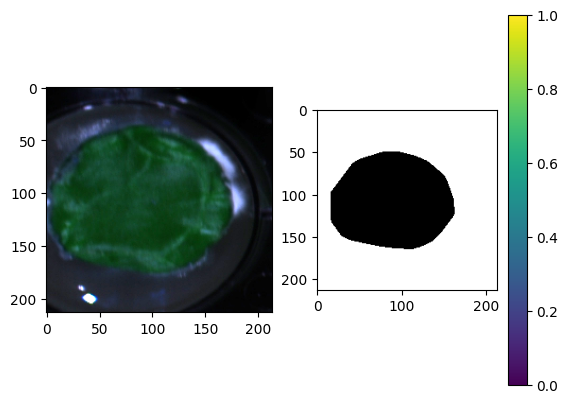

tensor(1.)


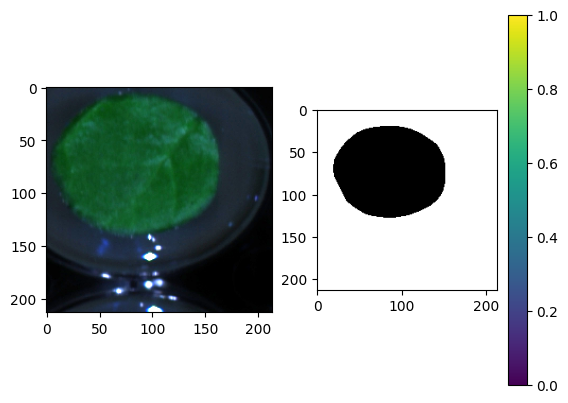

In [14]:
img, img_label, img_mask = None, None, None
rand_2 = torch.randint(0, len(plant_train_2), (2,))
for i in rand_2:
    img, img_label, img_mask = plant_train_2[i]
    print(img_label)
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(img.permute(1, 2, 0).squeeze().numpy())
    im_mask = ax[1].imshow(img_mask.permute(1, 2, 0).squeeze().numpy())
    fig.colorbar(im_mask, ax=ax[1])
    plt.show()

In [15]:
dl_train = plant.get_dataloader(plant_train_2, batch_size)
dl_test = plant.get_dataloader(plant_test_2, test_batch_size)

In [16]:
def visualize_gradient(model, batch_input, batch_labels, batch_mask, epsilon, elem_idx, has_conv, curr_device):
    channel_to_view = 1
    batch_input, batch_labels, batch_mask = batch_input.to(curr_device), batch_labels.to(curr_device), batch_mask.to(curr_device)
    model.to(curr_device)
    grad_bounds = input_gradient_interval_regularizer(
        model, batch_input, batch_labels, "binary_cross_entropy", epsilon, 0.0, return_grads=True, regularizer_type="r4",
        batch_masks=batch_mask, has_conv=has_conv, device=curr_device
    )
    dx_l, dx_u = grad_bounds[1]
    dx_n, _ = grad_bounds[0]
    print(f"input lower bound shape: {dx_l.shape}")
    print(f"input upper bound shape: {dx_u.shape}")
    print(f"input gradient shape: {dx_n.shape}")
    fig, ax = plt.subplots(3, 2, figsize=(14, 13))
    lesion = batch_input[elem_idx].permute(1, 2, 0).cpu().numpy()
    mask = batch_mask[elem_idx].permute(1, 2, 0).cpu().numpy()
    # choose only 1 channel gradient to view, because with 3 channels, the bounds do not represent rgb values
    dx_l_view, dx_u_view, dx_n_view = dx_l[elem_idx][channel_to_view].squeeze(), dx_u[elem_idx][channel_to_view].squeeze(), dx_n[elem_idx][channel_to_view].squeeze()
    ax[0][0].imshow(lesion)
    ax[0][0].set_title(f"Input at index {elem_idx}")
    im_mask = ax[0][1].imshow(mask, cmap='gray')
    ax[0][1].set_title(f"Mask at index {elem_idx}")
    fig.colorbar(im_mask, ax=ax[0][1])
    im_dx_l = ax[1][0].imshow(dx_l_view.cpu().detach().numpy())
    ax[1][0].set_title(f"Lower bound of gradient at index {elem_idx}")
    fig.colorbar(im_dx_l, ax=ax[1][0])
    im_dx_u = ax[1][1].imshow(dx_u_view.cpu().detach().numpy())
    ax[1][1].set_title(f"Upper bound of gradient at index {elem_idx}")
    cbu = fig.colorbar(im_dx_u, ax=ax[1][1])
    cbu.ax.invert_yaxis()
    im_dx_n = ax[2][0].imshow(dx_n_view.cpu().detach().numpy())
    ax[2][0].set_title(f"Gradient at index {elem_idx}")
    fig.colorbar(im_dx_n, ax=ax[2][0])

In [17]:
epsilon = 0.01
model = PlantNet(3, 1)
criterion = torch.nn.BCELoss()
gpu_ids = [i for i in range(torch.cuda.device_count())]
print(gpu_ids)
model = torch.nn.DataParallel(model, device_ids=gpu_ids)
model = model.to(device)

[0, 1]


In [18]:
idx_to_visualize = torch.randint(0, batch_size, (1,)).item()
print(idx_to_visualize)
init_batch_train_with_masks = next(iter(dl_train))
print(f"Batch input shape: {init_batch_train_with_masks[0].shape}, batch mask shape: {init_batch_train_with_masks[2].shape}")
# visualize_gradient(model, *init_batch_train_with_masks, epsilon, idx_to_visualize, True, device)

1
Batch input shape: torch.Size([50, 3, 213, 213]), batch mask shape: torch.Size([50, 3, 213, 213])


## Experiments 

In [19]:
DELTA_INPUT_ROBUSTNESS_PARAM = 1
model_root_save_dir = "saved_experiment_models/plant"
os.makedirs(model_root_save_dir, exist_ok=True)
methods = ["std", "r3", "r4", "ibp_ex", "ibp_ex+r3"]
save_dir_for_method = {method: os.path.join(model_root_save_dir, method) for method in methods}
for method in methods:
    os.makedirs(save_dir_for_method[method], exist_ok=True)

### Standard Training

In [ ]:
std_method = "std"
# Hyperparameters
num_epochs, lr, restarts, epsilon, k, weight_coeff = 7, 1e-3, 3, 0.1, 0.2, -1
# k is a coefficient for the regularization term
train_acc, test_acc, num_robust, min_robust_delta, min_lower_bound, max_upper_bound = 0, 0, 0, 1e+8, 0, 0
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = PlantNet(3, 1)
    print(f"========== Training model with method {std_method} restart {i} ==========")
    train_model_with_certified_input_grad(dl_train, num_epochs, curr_model, lr, criterion, epsilon, std_method, k, device, True)
    print("Testing model accuracy for the training set")
    train_acc += test_model_accuracy(curr_model, dl_train, device)
    print("Testing model accuracy for the test set")
    test_acc += test_model_accuracy(curr_model, dl_test, device)
    n_r, min_delta, m_l, m_u = test_delta_input_robustness(dl_test, curr_model, epsilon, DELTA_INPUT_ROBUSTNESS_PARAM,
                                                 "binary_cross_entropy", device, has_conv=True)
    num_robust += num_robust
    min_robust_delta = min(min_robust_delta, min_delta)
    min_lower_bound += m_l
    max_upper_bound += m_u
    torch.save(curr_model.state_dict(), os.path.join(save_dir_for_method[std_method], f"run_{i}.pt"))
write_results_to_file("experiment_results/plant.yaml",
                      {"train_acc": round(train_acc / restarts, 3),
                       "test_acc": round(test_acc / restarts, 3),
                       "num_robust": round(num_robust / restarts, 3),
                       "min_lower_bound": round(min_lower_bound / restarts, 3),
                       "max_upper_bound": round(max_upper_bound / restarts, 3),
                       "min_robust_delta": min_robust_delta}, std_method)
write_results_to_file("experiment_results/plant_params.yaml",
                        {"epsilon": epsilon,
                         "k": k,
                         "weight_coeff": weight_coeff,
                         "num_epochs": num_epochs,
                         "lr": lr,
                         "restarts": restarts,
                         "delta_threshold": DELTA_INPUT_ROBUSTNESS_PARAM}, std_method)

========== Training model with method std restart 0 ==========


Epoch: 100%|██████████| 7/7 [02:15<00:00, 19.33s/it, loss=0.4, reg=0]  


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.89
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.88
--- Delta input robustness ---
Delta Input Robustness = 0
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 7.52e+03
========== Training model with method std restart 1 ==========


Epoch: 100%|██████████| 7/7 [02:14<00:00, 19.23s/it, loss=0.439, reg=0]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.86
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.86
--- Delta input robustness ---
Delta Input Robustness = 0
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 7.13e+03
========== Training model with method std restart 2 ==========


Epoch: 100%|██████████| 7/7 [02:14<00:00, 19.24s/it, loss=0.441, reg=0]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.85
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.86
--- Delta input robustness ---
Delta Input Robustness = 0
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 6.55e+03


### RRR Training

In [ ]:
# Train standard 3 times and test accuracy and delta input robustness for the masked region
rrr_method = "r3"
# hyperparams
num_epochs, lr, restarts, epsilon, weight_coeff, k = 8, 1e-3, 3, 0.01, 1e-4, 4e-2
train_acc, test_acc, num_robust, min_robust_delta, min_lower_bound, max_upper_bound = 0, 0, 0, 1e+8, 0, 0
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = PlantNet(3, 1)

    print(f"========== Training model with method {rrr_method}, restart {i} ==========")
    train_model_with_certified_input_grad(dl_train, num_epochs, curr_model, lr, criterion, epsilon, rrr_method,
        k, device, True, k_schedule=uniformize_magnitudes_schedule, weight_reg_coeff=weight_coeff)
    print("Testing model accuracy for the training set")
    train_acc += test_model_accuracy(curr_model, dl_train, device)
    print("Testing model accuracy for the test set")
    test_acc += test_model_accuracy(curr_model, dl_test, device)
    n_r, min_delta, m_l, m_u = test_delta_input_robustness(dl_test, curr_model, epsilon, DELTA_INPUT_ROBUSTNESS_PARAM,
                                "binary_cross_entropy", device, has_conv=True)
    num_robust += n_r
    min_robust_delta = min(min_robust_delta, min_delta)
    min_lower_bound += m_l
    max_upper_bound += m_u
    torch.save(curr_model.state_dict(), os.path.join(save_dir_for_method[rrr_method], f"run_{i}.pt"))
write_results_to_file("experiment_results/plant.yaml",
                      {"train_acc": round(train_acc / restarts, 3),
                       "test_acc": round(test_acc / restarts, 3),
                       "num_robust": round(num_robust / restarts, 3),
                       "min_lower_bound": round(min_lower_bound / restarts, 3),
                       "max_upper_bound": round(max_upper_bound / restarts, 3),
                       "min_robust_delta": min_robust_delta}, rrr_method)
write_results_to_file("experiment_results/plant_params.yaml",
                      {"epsilon": epsilon,
                       "k": k,
                       "weight_coeff": weight_coeff,
                       "num_epochs": num_epochs,
                       "lr": lr,
                       "restarts": restarts,
                       "delta_threshold": DELTA_INPUT_ROBUSTNESS_PARAM}, rrr_method)

========== Training model with method r3, restart 0 ==========


Epoch: 100%|██████████| 8/8 [05:52<00:00, 44.08s/it, loss=0.563, reg=tensor(0.0428, device='cuda:0', grad_fn=<AddBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.79
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.79
--- Delta input robustness ---
Delta Input Robustness = 0
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 13.2
========== Training model with method r3, restart 1 ==========


Epoch: 100%|██████████| 8/8 [05:47<00:00, 43.45s/it, loss=0.569, reg=tensor(0.0390, device='cuda:0', grad_fn=<AddBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.79
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.79
--- Delta input robustness ---
Delta Input Robustness = 0
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 8.12
========== Training model with method r3, restart 2 ==========


Epoch: 100%|██████████| 8/8 [05:46<00:00, 43.31s/it, loss=0.562, reg=tensor(0.0497, device='cuda:0', grad_fn=<AddBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.79
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.79
--- Delta input robustness ---
Delta Input Robustness = 0
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 6.25


### R4 Training

In [ ]:
# Train standard 3 times and test accuracy and delta input robustness for the masked region
r4_method = "r4"
# hyperparams
num_epochs, lr, restarts, epsilon, weight_coeff, k, alpha = 10, 4e-4, 3, 0.01, -1, 1e-2, 0.5
train_acc, test_acc, num_robust, min_robust_delta, min_lower_bound, max_upper_bound = 0, 0, 0, 1e+8, 0, 0
soft_train = plant.make_soft_masks(dl_train, alpha)
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = PlantNet(3, 1)

    print(f"========== Training model with method {r4_method}, restart {i} ==========")
    train_model_with_certified_input_grad(soft_train, num_epochs, curr_model, lr, criterion, epsilon, r4_method,
        k, device, True, weight_reg_coeff=weight_coeff)
    print("Testing model accuracy for the training set")
    train_acc += test_model_accuracy(curr_model, soft_train, device)
    print("Testing model accuracy for the test set")
    test_acc += test_model_accuracy(curr_model, dl_test, device)
    n_r, min_delta, m_l, m_u = test_delta_input_robustness(dl_test, curr_model, epsilon, DELTA_INPUT_ROBUSTNESS_PARAM,
                                "binary_cross_entropy", device, has_conv=True)
    num_robust += n_r
    min_robust_delta = min(min_robust_delta, min_delta)
    min_lower_bound += m_l
    max_upper_bound += m_u
    torch.save(curr_model.state_dict(), os.path.join(save_dir_for_method[r4_method], f"run_{i}.pt"))
write_results_to_file("experiment_results/plant.yaml",
                      {"train_acc": round(train_acc / restarts, 3),
                       "test_acc": round(test_acc / restarts, 3),
                       "num_robust": round(num_robust / restarts, 3),
                       "min_lower_bound": round(min_lower_bound / restarts, 3),
                       "max_upper_bound": round(max_upper_bound / restarts, 3),
                       "min_robust_delta": min_robust_delta}, r4_method)
write_results_to_file("experiment_results/plant_params.yaml",
                      {"epsilon": epsilon,
                       "k": k,
                       "weight_coeff": weight_coeff,
                       "num_epochs": num_epochs,
                       "lr": lr,
                       "restarts": restarts,
                       "delta_threshold": DELTA_INPUT_ROBUSTNESS_PARAM,
                       "alpha_soft": alpha}, r4_method)

shape of new masks: torch.Size([1806, 3, 213, 213])
========== Training model with method r4, restart 0 ==========


Epoch:   0%|          | 0/10 [00:01<?, ?it/s, loss=8.32, reg=tensor(762.5068, device='cuda:0', grad_fn=<DivBackward0>)]

### IBP_EX Training

In [ ]:
ibp_ex_method = "ibp_ex"
# hyperparams
num_epochs, lr, restarts, epsilon, weight_coeff, k = 8, 5e-4, 3, 0.01, 1e-4, 5e-2
train_acc, test_acc, num_robust, min_robust_delta, min_lower_bound, max_upper_bound = 0, 0, 0, 1e+8, 0, 0
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = PlantNet(3, 1)

    print(f"========== Training model with method {ibp_ex_method}, restart {i} ==========")
    train_model_with_certified_input_grad(dl_train, num_epochs, curr_model, lr, criterion, epsilon, ibp_ex_method,
        k, device, True, weight_reg_coeff=weight_coeff)
    print("Testing model accuracy for the training set")
    train_acc += test_model_accuracy(curr_model, dl_train, device)
    print("Testing model accuracy for the test set")
    test_acc += test_model_accuracy(curr_model, dl_test, device)
    n_r, min_delta, m_l, m_u = test_delta_input_robustness(dl_test, curr_model, epsilon, DELTA_INPUT_ROBUSTNESS_PARAM,
                                "binary_cross_entropy", device, has_conv=True)
    num_robust += n_r
    min_robust_delta = min(min_robust_delta, min_delta)
    min_lower_bound += m_l
    max_upper_bound += m_u
    torch.save(curr_model.state_dict(), os.path.join(save_dir_for_method[ibp_ex_method], f"run_{i}.pt"))
write_results_to_file("experiment_results/plant.yaml",
                      {"train_acc": round(train_acc / restarts, 3),
                       "test_acc": round(test_acc / restarts, 3),
                       "num_robust": round(num_robust / restarts, 3),
                       "min_lower_bound": round(min_lower_bound / restarts, 3),
                       "max_upper_bound": round(max_upper_bound / restarts, 3),
                       "min_robust_delta": min_robust_delta}, ibp_ex_method)
write_results_to_file("experiment_results/plant_params.yaml",
                      {"epsilon": epsilon,
                       "k": k,
                       "weight_coeff": weight_coeff,
                       "num_epochs": num_epochs,
                       "lr": lr,
                       "restarts": restarts,
                       "delta_threshold": DELTA_INPUT_ROBUSTNESS_PARAM}, ibp_ex_method)

========== Training model with method ibp_ex, restart 0 ==========


Epoch: 100%|██████████| 8/8 [03:10<00:00, 23.80s/it, loss=4.38, reg=tensor(76.1142, device='cuda:1', grad_fn=<AddBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.88
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.85
--- Delta input robustness ---
Delta Input Robustness = 0
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 606
========== Training model with method ibp_ex, restart 1 ==========


Epoch: 100%|██████████| 8/8 [03:10<00:00, 23.77s/it, loss=4.2, reg=tensor(76.1191, device='cuda:1', grad_fn=<AddBackward0>)] 


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.88
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.87
--- Delta input robustness ---
Delta Input Robustness = 0
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 604
========== Training model with method ibp_ex, restart 2 ==========


Epoch: 100%|██████████| 8/8 [03:10<00:00, 23.77s/it, loss=4.29, reg=tensor(76.1388, device='cuda:1', grad_fn=<AddBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.87
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.83
--- Delta input robustness ---
Delta Input Robustness = 0
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 808


### IBP_EX+R3 Training

In [ ]:
ibp_ex_and_r3_method = "ibp_ex+r3"
# hyperparams
num_epochs, lr, restarts, epsilon, weight_coeff, k = 8, 5e-4, 3, 0.01, 1e-4, 7e-2
train_acc, test_acc, num_robust, min_robust_delta, min_lower_bound, max_upper_bound = 0, 0, 0, 1e+8, 0, 0
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = PlantNet(3, 1)

    print(f"========== Training model with method {ibp_ex_and_r3_method}, restart {i} ==========")
    train_model_with_certified_input_grad(dl_train, num_epochs, curr_model, lr, criterion, epsilon, ibp_ex_and_r3_method,
        k, device, True, weight_reg_coeff=weight_coeff)
    print("Testing model accuracy for the training set")
    train_acc += test_model_accuracy(curr_model, dl_train, device)
    print("Testing model accuracy for the test set")
    test_acc += test_model_accuracy(curr_model, dl_test, device)
    n_r, min_delta, m_l, m_u = test_delta_input_robustness(dl_test, curr_model, epsilon, DELTA_INPUT_ROBUSTNESS_PARAM,
                                "binary_cross_entropy", device, has_conv=True)
    num_robust += n_r
    min_robust_delta = min(min_robust_delta, min_delta)
    min_lower_bound += m_l
    max_upper_bound += m_u
    torch.save(curr_model.state_dict(), os.path.join(save_dir_for_method[ibp_ex_and_r3_method], f"run_{i}.pt"))
write_results_to_file("experiment_results/plant.yaml",
                      {"train_acc": round(train_acc / restarts, 3),
                       "test_acc": round(test_acc / restarts, 3),
                       "num_robust": round(num_robust / restarts, 3),
                       "min_lower_bound": round(min_lower_bound / restarts, 3),
                       "max_upper_bound": round(max_upper_bound / restarts, 3),
                       "min_robust_delta": min_robust_delta}, ibp_ex_and_r3_method)
write_results_to_file("experiment_results/plant_params.yaml",
                      {"epsilon": epsilon,
                       "k": k,
                       "weight_coeff": weight_coeff,
                       "num_epochs": num_epochs,
                       "lr": lr,
                       "restarts": restarts,
                       "delta_threshold": DELTA_INPUT_ROBUSTNESS_PARAM}, ibp_ex_and_r3_method)

========== Training model with method ibp_ex+r3, restart 0 ==========


Epoch: 100%|██████████| 8/8 [06:17<00:00, 47.18s/it, loss=5.8, reg=tensor(77.4121, device='cuda:1', grad_fn=<AddBackward0>)] 


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.91
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.82
--- Delta input robustness ---
Delta Input Robustness = 0
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 296
========== Training model with method ibp_ex+r3, restart 1 ==========


Epoch: 100%|██████████| 8/8 [06:16<00:00, 47.07s/it, loss=5.8, reg=tensor(77.0183, device='cuda:1', grad_fn=<AddBackward0>)] 


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.86
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.85
--- Delta input robustness ---
Delta Input Robustness = 0
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 317
========== Training model with method ibp_ex+r3, restart 2 ==========


Epoch: 100%|██████████| 8/8 [06:16<00:00, 47.05s/it, loss=5.78, reg=tensor(77.1899, device='cuda:1', grad_fn=<AddBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.86
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.8
--- Delta input robustness ---
Delta Input Robustness = 0
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 395


In [ ]:
mask_ratios = [0.8, 0.6, 0.4, 0.2]
methods = ["r3", "r4", "ibp_ex", "ibp_ex+r3"]
for method in methods:
    # Load the params
    params_dict = load_params_or_results_from_file("experiment_results/decoy_mnist_params.yaml", method)
    delta_threshold = params_dict["delta_threshold"]
    epsilon = params_dict["epsilon"]
    k = params_dict["k"]
    weight_coeff = params_dict["weight_coeff"]
    num_epochs = params_dict["num_epochs"]
    lr = params_dict["lr"]
    restarts = params_dict["restarts"]
    for mask_ratio in mask_ratios:
        new_dl_train = plant.remove_masks(mask_ratio, dl_train)
        if method == "r4":
            new_dl_train = plant.make_soft_masks(new_dl_train, params_dict["alpha_soft"])
        train_acc, test_acc, num_robust, min_robust_delta, min_lower_bound, max_upper_bound = 0, 0, 0, 1e+8, 0, 0
        for i in range(restarts):
            # Reinitialize the model
            # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
            torch.manual_seed(i + SEED)
            curr_model = PlantNet(3, 1)

            print(f"========== Training model with method {method} restart {i} and mask ratio {mask_ratio} ==========")
            k_schedule = uniformize_magnitudes_schedule if method in ["r3", "ibp_ex", "ibp_ex+r3"] else None
            train_model_with_certified_input_grad(new_dl_train, num_epochs, curr_model, lr, criterion, epsilon, method,
                                                  k, device, True, weight_reg_coeff=weight_coeff, k_schedule=k_schedule)
            train_acc += test_model_accuracy(curr_model, new_dl_train, device, suppress_log=True)
            test_acc += test_model_accuracy(curr_model, dl_test, device, suppress_log=True)
            n_r, min_delta, m_l, m_u = test_delta_input_robustness(dl_test, curr_model, epsilon, delta_threshold,
                                                         "binary_cross_entropy", device, has_conv=True, suppress_log=True)
            num_robust += n_r
            min_robust_delta = min(min_robust_delta, min_delta)
            min_lower_bound += m_l
            max_upper_bound += m_u
        write_results_to_file(f"experiment_results/plant_sample_complexity.yaml",
                            {"train_acc": round(train_acc / restarts, 3),
                             "test_acc": round(test_acc / restarts, 3),
                             "num_robust": round(num_robust / restarts, 3),
                             "min_lower_bound_avg": round(min_lower_bound / restarts, 3),
                             "max_upper_bound_avg": round(max_upper_bound / restarts, 3),
                             "min_robust_delta": min_robust_delta}, method + f"_{int(mask_ratio * 100)}")